In [1]:
# %load_ext autoreload
# %autoreload 2

import das_package as dp
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import scipy.signal as sp

In [2]:
interrogator = "Optasense"     #Optasense or Silixa
ship_number = 1
folder = f"Data/Raw/Ship{ship_number}"
results_folder = f"{folder}/results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
# url = "http://piweb.ooirsn.uw.edu/das/data/Silixa/DAS/South90km/2021-11-05/OOIPacCity_UTC_20211105_163824.042.tdms"
url = "http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/ReceiveFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T07_21_18-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163316Z.h5"
first_file_time = dp.find_time_url(url, interrogator)
file_timing_length = 60
minutes = 5
n = int(minutes*60/file_timing_length)
all_filenames = dp.dl_das_files(folder, url, first_file_time, file_timing_length, n)
filenames = sorted([file for file in all_filenames if file != f"{folder}/results"])
print(filenames)

South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163316Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163416Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163516Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163616Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163716Z.h5 already stored locally
['Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163316Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163416Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163516Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163616Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163716Z.h5']


In [3]:
if interrogator == 'Optasense':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.optasense(filenames)

elif interrogator == 'Silixa':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.silixa(filenames)


# Downsample factors and channel chunking size
if fs == 1000:
    factor_channels = 2
    factor_time = 5
    ch_chunk_size = 500
elif fs == 500:
    factor_channels = 2
    factor_time = 2
    ch_chunk_size = 700
elif fs == 200:
    factor_channels = 2
    factor_time = 1
    ch_chunk_size = 1000

The concatenated data shape: (47500, 60000)
The first value in "RawDataTime" is 1636129996713000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-05 16:33:16.713000
the time step is equal to =  5000.0 microsecond

sampling rate in Hz =  200.0
channel spacing in m =  2.0419047
number of channels =  47500
number of samples in each channel =  60000
gauge length in m =  51.04762


In [4]:
distance = [1000, 90000]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    # str_rate = dp.strain2strainrate(trace, dt, tint)
    str_rate = trace
elif interrogator == 'Silixa':
    str_rate = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist = np.concatenate([dist, dist_chunk])
    if interrogator == 'Optasense':
        # str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
        str_rate_chunk = trace
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate = np.concatenate([str_rate, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}', str_rate)
np.save(f'{folder}/results/time{ship_number}', time)
np.save(f'{folder}/results/dist{ship_number}', dist)

del trace, rawData

if interrogator == 'Optasense':
    files = glob.glob(os.path.join(folder, '*.h5'))
    print(files)
    for file in files:
        os.remove(file)

elif interrogator == 'Silixa':
    files = glob.glob(os.path.join(folder, '*.tdms'))
    print(files)
    for file in files:
        os.remove(file)


Number of itterations:  43.0


100%|██████████| 43/43 [27:34<00:00, 38.47s/it]


['Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163416Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163316Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163616Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163716Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz-ReceiveFiber_2021-11-05T163516Z.h5']


In [5]:
# Downsample the raw data
factor_channels = 1
factor_time = 1
str_rate_downsampled = block_reduce(str_rate, block_size=(factor_channels, factor_time), func=np.mean)
# Downsample the distance and time domain data
dist_downsampled = block_reduce(dist, block_size=factor_channels, func=np.mean)
time_downsampled = block_reduce(time, block_size=factor_time, func=np.mean)

<function matplotlib.pyplot.show(close=None, block=None)>

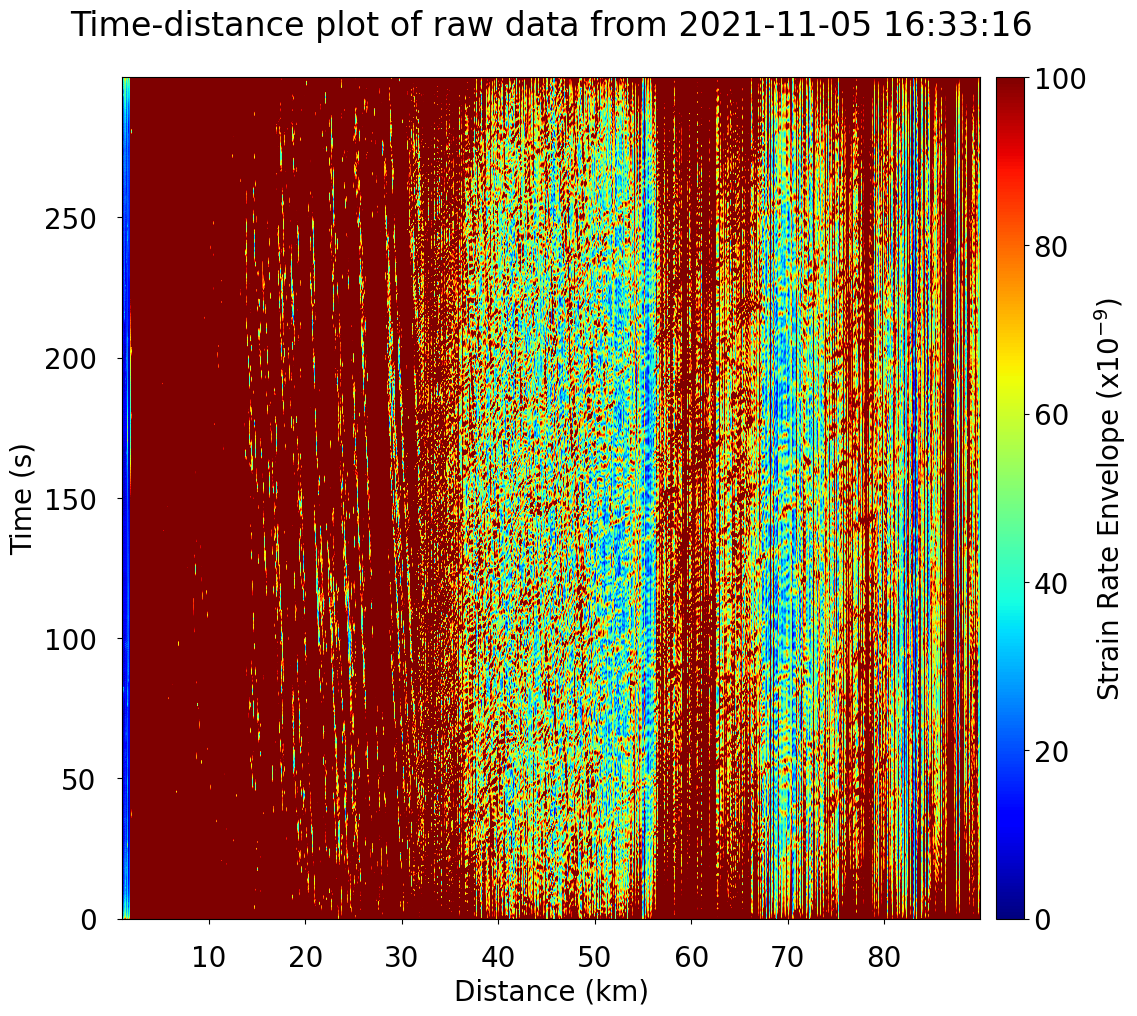

In [6]:
vmax = 100
dp.plot_tx(sp.hilbert(str_rate_downsampled[0:-2,:], axis=1), time_downsampled, dist_downsampled[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

In [8]:
print(f"size of strain-rate data: {str_rate.shape}")

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(str_rate)

# Step 1: Temporal PCA
pca = PCA(n_components=int(str_rate.shape[1]/1000))
str_rate_reduced = pca.fit_transform(scaled_data)  # Reduce time

print(f"size of reduced strain-rate data: {str_rate_reduced.shape}")

size of strain-rate data: (43587, 60000)
size of reduced strain-rate data: (43587, 60)


In [9]:
original_data = str_rate_reduced.copy()

In [34]:
from tensorflow.keras import backend as K
def physics_informed_loss(y_true, y_pred):
    bce = K.binary_crossentropy(y_true, K.clip(y_pred, K.epsilon(), 1 - K.epsilon()))
    smoothness_penalty = K.mean(K.square(y_pred[:, 1:] - y_pred[:, :-1])) if y_pred.shape[1] > 1 else 0.0
    
    return bce + 0.01 * smoothness_penalty

In [11]:
X_new_reshaped = str_rate_reduced.reshape(-1, 60)  # Match the input shape

In [14]:
from tensorflow.keras.models import load_model
model_rnn = load_model('model_rnn.h5', custom_objects={'physics_informed_loss': physics_informed_loss})

2024-12-05 13:20:40.709082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 13:20:40.713671: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 13:20:42.561412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 13:20:42.730854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733433643.373300   90972 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733433643.51

In [15]:
y_new_pred = model_rnn.predict(X_new_reshaped)
y_new_pred_binary = (y_new_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

1363/1363 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [21]:
y = np.array(y_new_pred_binary)

In [24]:
y[:,0]

array([0, 0, 0, ..., 0, 0, 0])

# Figure showing predicted ship signals from RNN

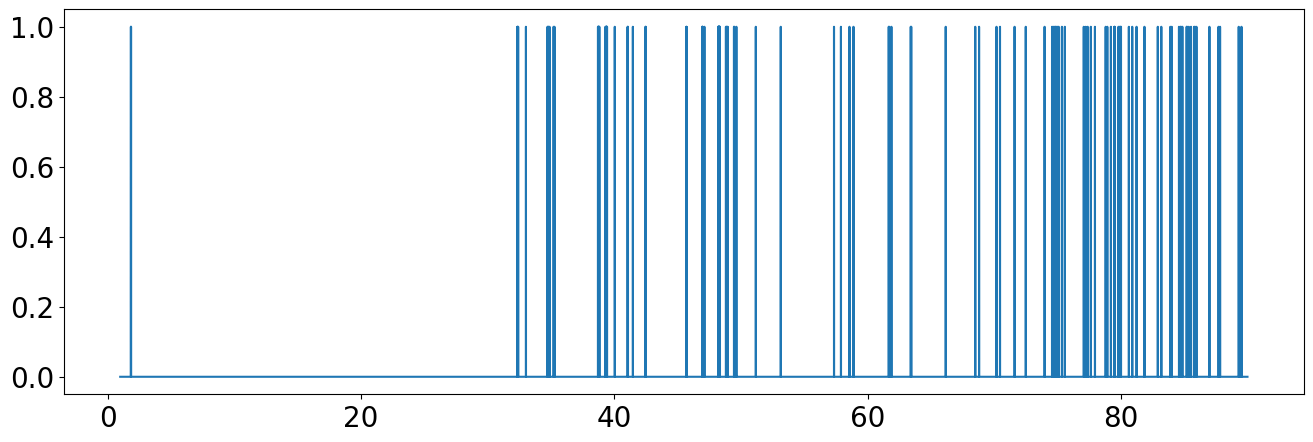

In [31]:
plt.figure(figsize=(16, 5))
plt.plot(dist_downsampled/1000, y[:,0])
# plt.xlim(40, 60)

In [32]:
from sklearn.model_selection import train_test_split

metadata = np.zeros(str_rate_reduced.shape[0])

# Defining distances where ship was present in our data
start_distance = 46500
end_distance = 48500

# add ship label to the metadata for points in the specified distance and time range from above
print(f"start channel: {int((start_distance-distance[0])/(dx*chint))}\nend channel: {int((end_distance-distance[0])/(dx*chint))}")
metadata[int((start_distance-distance[0])/(dx*chint)):int((end_distance-distance[0])/(dx*chint))] = 1
print(metadata.shape)

# Flatten the metadata to match the data dimensions
y = metadata.flatten()
print(y.shape)

# Reshape data to (samples, features) for ML/DL models
X = str_rate_reduced.reshape(-1, 60)  # Adjust depending on ML model requirements
print(X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


start channel: 22283
end channel: 23262
(43587,)
(43587,)
(43587, 60)


In [35]:
for layer in model_rnn.layers:
    layer.trainable = True

model_rnn.compile(optimizer='adam', loss=physics_informed_loss, metrics=['accuracy'])

model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9769 - loss: 0.1159 - val_accuracy: 0.9745 - val_loss: 0.0879
Epoch 2/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9791 - loss: 0.0629 - val_accuracy: 0.9780 - val_loss: 0.0561
Epoch 3/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9805 - loss: 0.0501 - val_accuracy: 0.9836 - val_loss: 0.0432
Epoch 4/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9863 - loss: 0.0383 - val_accuracy: 0.9874 - val_loss: 0.0429
Epoch 5/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9891 - loss: 0.0311 - val_accuracy: 0.9890 - val_loss: 0.0314
Epoch 6/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9916 - loss: 0.0226 - val_accuracy: 0.9892 - val_loss: 0.0301
Epoch 7/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9938 - loss: 0.0184 - val_accuracy: 0.9901 - val_loss: 0.0262
Epoch 8/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9952 -

In [37]:
test_loss, test_accuracy = model_rnn.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9967 - loss: 0.0132
Test loss: 0.016562391072511673, Test accuracy: 0.9956412315368652


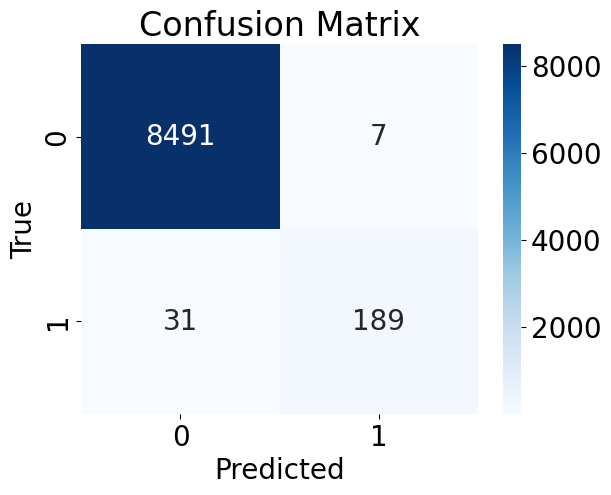

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [40]:
y_pred = model_rnn.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [45]:
frqmin = 5
frqmax = 30
b, a = sp.butter(8,[frqmin/(fs/2/tint),frqmax/(fs/2/tint)],'bp')
tr = sp.filtfilt(b,a,str_rate_downsampled,axis=1)

In [42]:
from scipy import signal
str_rate_decimated = signal.decimate(str_rate_downsampled, 4)

In [43]:
str_rate_decimated.shape

(43587, 15000)

<function matplotlib.pyplot.show(close=None, block=None)>

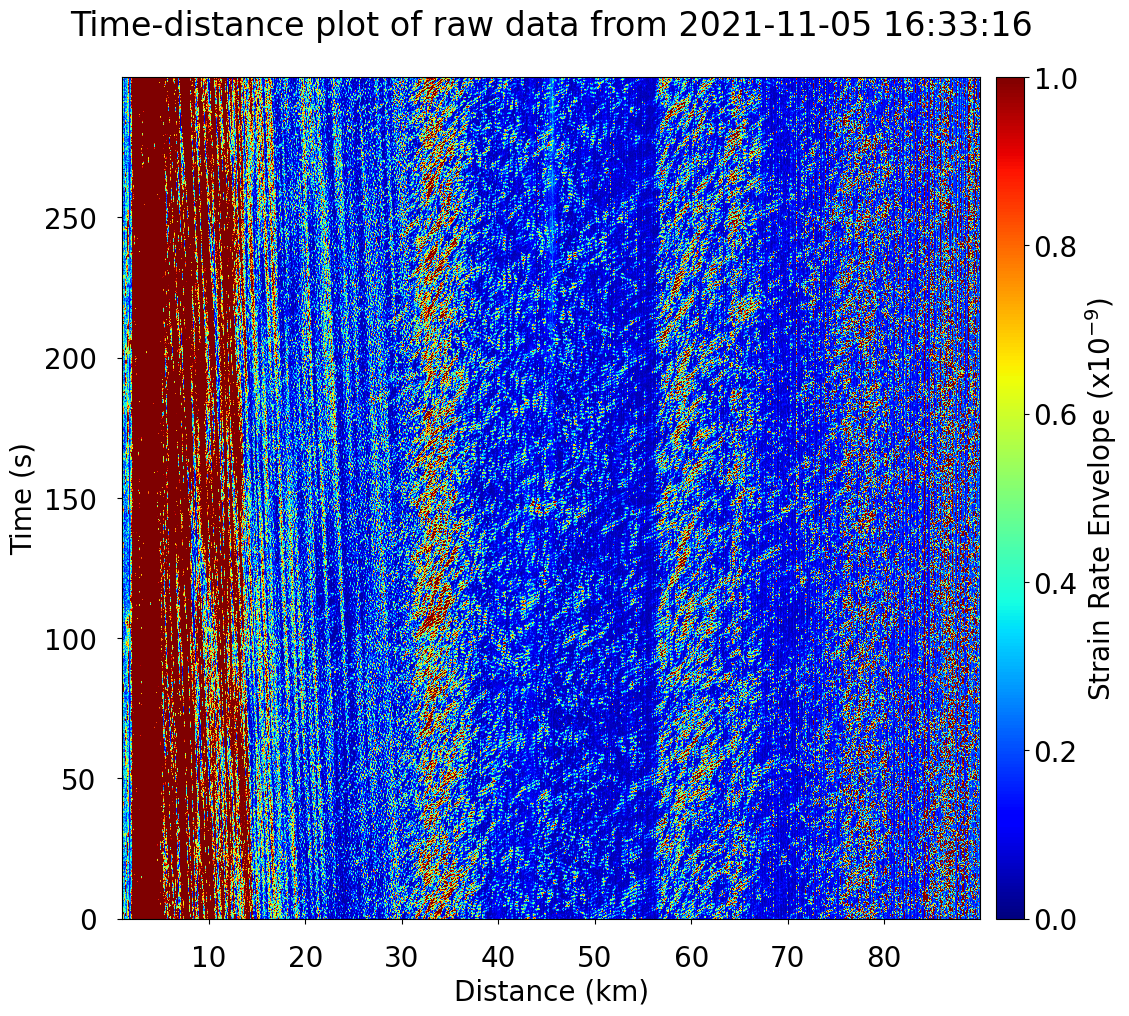

In [48]:
vmax = 1
dp.plot_tx(sp.hilbert(tr[0:-2,:], axis=1), time_downsampled, dist_downsampled[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

In [49]:
#make strain rate a pandas dataframe
import pandas as pd

#turn it into a 3d dataframe with time and distance
df = pd.DataFrame(str_rate_reduced)

#add label to the distance and time
df.index.name = 'Distance'
df.columns.name = 'Time'

#find number of columns
num_columns = len(df.columns)
print(num_columns)

60


In [51]:
metadata_CNN = pd.DataFrame(index = df.index, columns = ["ship class"])
metadata_CNN = metadata_CNN.fillna(0)


# Find the closest index values for the given distances
start_distance = 46500
end_distance = 48500

# add ship label to the metadata for points in the specified distance and time range from above
print(f"start channel: {int((start_distance-distance[0])/(dx*chint))}\nend channel: {int((end_distance-distance[0])/(dx*chint))}")
metadata_CNN.iloc[int((start_distance-distance[0])/(dx*chint)):int((end_distance-distance[0])/(dx*chint))] = 1

start channel: 22283
end channel: 23262


/tmp/ipykernel_90972/1882853395.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata_CNN = metadata_CNN.fillna(0)


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# CNN Model Definition
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model_cnn = build_cnn(input_shape=(60, 1))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
model_cnn.save('model_cnn.h5')

Epoch 1/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9796 - loss: 0.1023 - val_accuracy: 0.9890 - val_loss: 0.0355
Epoch 2/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9887 - loss: 0.0324 - val_accuracy: 0.9915 - val_loss: 0.0252
Epoch 3/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9929 - loss: 0.0206 - val_accuracy: 0.9945 - val_loss: 0.0162
Epoch 4/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9959 - loss: 0.0123 - val_accuracy: 0.9945 - val_loss: 0.0159
Epoch 5/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 0.9969 - val_loss: 0.0106
Epoch 6/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.9962 - val_loss: 0.0153
Epoch 7/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9984 - loss: 0.0053 - val_accuracy: 0.9933 - val_loss: 0.0269
Epoch 8/10
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9989 - loss: 0.0065 - 

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
Accuracy: 0.9976
Precision: 0.9543
Recall: 0.9500
F1 Score: 0.9522
RMSE: 0.0491


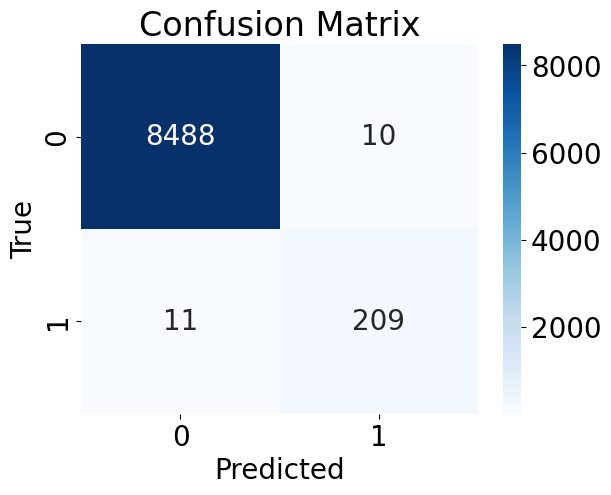

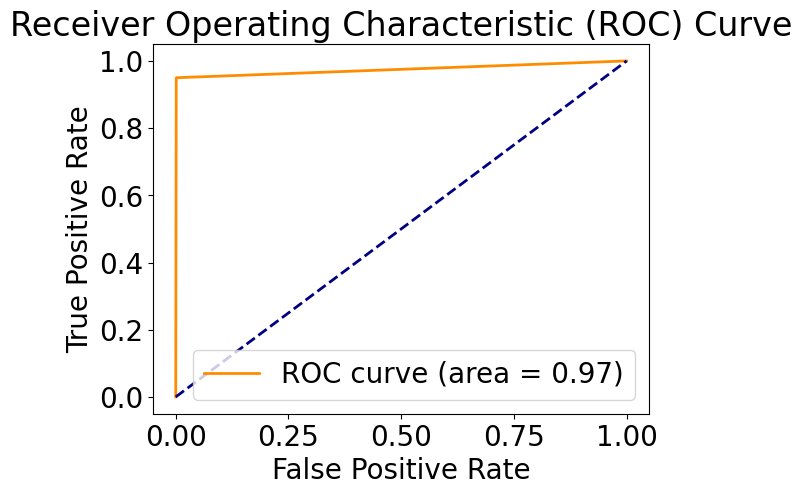

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
# Get predictions for the test set
y_pred = model_cnn.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
